In [185]:
import pandas as pd
import numpy as np

# 0. 데이터 세팅 준비

In [186]:
ori_train_data = pd.read_csv('/opt/ml/input/data/train_data.csv')
ori_test_data = pd.read_csv('/opt/ml/input/data/test_data.csv')

In [187]:
data = pd.concat([ori_train_data, ori_test_data])
data.drop_duplicates(
        subset=["userID", "assessmentItemID"], keep="last", inplace=True
    )

In [188]:
data.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [189]:
def indexing_data(data):
    userid, itemid = (
        sorted(list(set(data.userID))),
        sorted(list(set(data.assessmentItemID))),
    )
    n_user, n_item = len(userid), len(itemid)

    userid_2_index = {v: i for i, v in enumerate(userid)}
    itemid_2_index = {v: i for i, v in enumerate(itemid)}
    #id_2_index = dict(userid_2_index, **itemid_2_index)

    return userid_2_index, itemid_2_index

In [190]:
userid2index, itemid2index = indexing_data(data)

In [191]:
def process_data(data):
    u_list, i_list = [], []
    for user, item, acode in zip(data.userID, data.assessmentItemID, data.answerCode):
        uid, iid = userid2index[user], itemid2index[item]
        u_list.append(uid)
        i_list.append(iid)

    return u_list, i_list

In [192]:
data.reset_index(inplace=True, drop=True)

u_list, i_list = process_data(data)

In [193]:
data.userID = u_list
data.assessmentItemID = i_list

In [194]:
data.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,5354,A060000001,1,2020-03-24 00:17:11,7224
1,0,5355,A060000001,1,2020-03-24 00:17:14,7225
2,0,5356,A060000001,1,2020-03-24 00:17:22,7225
3,0,5357,A060000001,1,2020-03-24 00:17:29,7225
4,0,5358,A060000001,1,2020-03-24 00:17:36,7225


# 1. 데이터 분리 및 변환

- train

In [195]:
from sklearn.model_selection import train_test_split

data_all = data[data.answerCode > 0]
data_all.drop(2212840, axis=0, inplace=True) #7029가 1번이라

train_data_df, valid_data_df, _, _ = train_test_split(data_all, data_all['assessmentItemID'],
             test_size=0.3, shuffle=True, stratify=data_all['assessmentItemID'], random_state=3123)

/tmp/ipykernel_13516/3804533820.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all.drop(2212840, axis=0, inplace=True) #7029가 1번이라


In [196]:
print(len(train_data_df.assessmentItemID.unique()))
print(len(data.assessmentItemID.unique()))


9454
9454


In [197]:
print(len(train_data_df.userID.unique()))
print(len(data_all.userID.unique()))


7440
7440


In [198]:
from tqdm import tqdm

total = []
train_users = train_data_df.userID.unique()

for i in tqdm(range(len(train_users))):
    tmp = []
    
    tmp.append(train_users[i])
    tmp.extend(train_data_df[train_data_df['userID'] == train_users[i]]['assessmentItemID'].unique())

    total.append(tmp)

100%|██████████| 7440/7440 [00:08<00:00, 865.08it/s]


In [199]:
f = open("/opt/ml/input/code/ultragcn/ultra-data/train.txt",'a')
for i in range(len(total)):
    #data = "%d번째 줄입니다.\n" % i
    data_write = ''.join(str(total[i])[1:-1].split(','))+'\n' #% i
    f.write(data_write)
f.close()

- valid

In [200]:
from tqdm import tqdm

total = []
valid_users = valid_data_df.userID.unique()

for i in tqdm(range(len(valid_users))):
    tmp = []
    
    tmp.append(valid_users[i])
    tmp.extend(valid_data_df[valid_data_df['userID'] == valid_users[i]]['assessmentItemID'].unique())

    total.append(tmp)

100%|██████████| 7416/7416 [00:05<00:00, 1394.48it/s]


In [201]:
f = open("/opt/ml/input/code/ultragcn/ultra-data/test.txt",'a')
for i in range(len(total)):
    #data = "%d번째 줄입니다.\n" % i
    data_write = ''.join(str(total[i])[1:-1].split(','))+'\n' #% i
    f.write(data_write)
f.close()

- test

In [202]:
test_data_all = data[data.answerCode < 0]

In [203]:
from tqdm import tqdm

total = []
test_users = test_data_all.userID.unique()

for i in tqdm(range(len(test_users))):
    tmp = []
    
    tmp.append(test_users[i])
    tmp.extend(test_data_all[test_data_all['userID'] == test_users[i]]['assessmentItemID'].unique())

    total.append(tmp)

100%|██████████| 744/744 [00:00<00:00, 2573.89it/s]


In [204]:
f = open("/opt/ml/input/code/ultragcn/ultra-data/fin_test.txt",'a')
for i in range(len(total)):
    #data = "%d번째 줄입니다.\n" % i
    data_write = ''.join(str(total[i])[1:-1].split(','))+'\n' #% i
    f.write(data_write)
f.close()

# 2. 

In [205]:
users = pd.read_csv('users.csv')
groundTrue_list = pd.read_csv('groundTrue_list.csv')
pred_total = pd.read_csv('pred_total.csv')

In [208]:
users

,Unnamed: 0,0
0,0,3
1,1,4
2,2,13
3,3,17
4,4,26
...,...,...
739,739,7395
740,740,7404
741,741,7416
742,742,7417


In [207]:
groundTrue_list

,Unnamed: 0,0
0,0,4965
1,1,7748
2,2,7484
3,3,9381
4,4,6231
...,...,...
739,739,3692
740,740,2590
741,741,5353
742,742,5353


In [212]:
pred_total.columns = ['index', 'pred']
pred_total

,index,pred
0,0,-4.787788
1,1,-3.574510
2,2,-4.330842
3,3,-4.796431
4,4,-4.596459
...,...,...
739,739,-3.906345
740,740,-2.498160
741,741,-0.125663
742,742,0.224878


In [210]:
submit = pd.read_csv('/opt/ml/input/data/sample_submission.csv')
submit

,id,prediction
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
739,739,0.5
740,740,0.5
741,741,0.5
742,742,0.5


In [213]:
submit.prediction = pred_total.pred

In [214]:
submit

,id,prediction
0,0,-4.787788
1,1,-3.574510
2,2,-4.330842
3,3,-4.796431
4,4,-4.596459
...,...,...
739,739,-3.906345
740,740,-2.498160
741,741,-0.125663
742,742,0.224878


In [215]:
submit[submit.prediction > 0]


,id,prediction
716,716,0.235133
742,742,0.224878


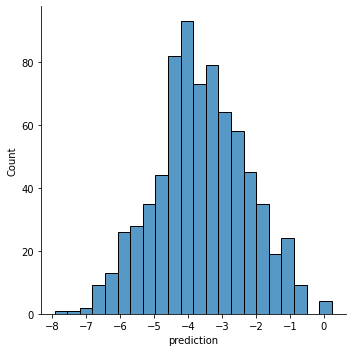

In [217]:
import seaborn as sns

sns.displot(submit, x="prediction")


In [222]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
submit.prediction = scaler.fit_transform(submit.prediction.values.reshape(-1, 1))

In [223]:
submit

,id,prediction
0,0,0.384221
1,1,0.532962
2,2,0.440240
3,3,0.383162
4,4,0.407677
...,...,...
739,739,0.492281
740,740,0.664916
741,741,0.955769
742,742,0.998743


In [224]:
submit[submit.prediction > 0.5]


,id,prediction
1,1,0.532962
14,14,0.556782
15,15,0.633569
16,16,0.510253
18,18,0.583846
...,...,...
737,737,0.605774
738,738,0.655262
740,740,0.664916
741,741,0.955769


In [225]:
submit.to_csv('ultragcn.csv')

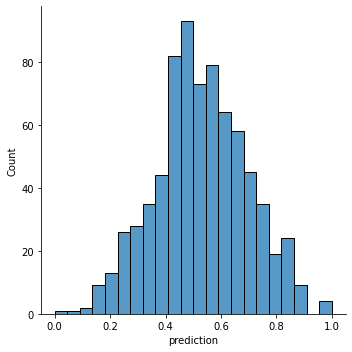

In [226]:
import seaborn as sns

sns.displot(submit, x="prediction")
